In [1]:
from TSMODEL import TimeSeriesModel
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Initialize the class with the file path
model = TimeSeriesModel(r'C:\New folder\Hope AI\Time Series\TSA_Network\enhanced_network_traffic_data5.csv')

# Load and preprocess data
model.load_and_preprocess_data()

# Split data into training and testing sets
train_data, test_data = model.df[:'2022'], model.df['2023':]

# SES model
ses_models, ses_forecasts = model.fit_ses(train_data, test_data)
rmse_ses, mape_ses = model.evaluate_forecast(test_data['Network_Traffic'], ses_forecasts['Network_Traffic'])
print(f"SES - RMSE: {rmse_ses}, MAPE: {mape_ses}")

# Holt's Linear Trend model
holt_models, holt_forecasts = model.fit_holt(train_data, test_data)
rmse_holt, mape_holt = model.evaluate_forecast(test_data['Network_Traffic'], holt_forecasts['Network_Traffic'])
print(f"Holt's Linear Trend - RMSE: {rmse_holt}, MAPE: {mape_holt}")

# Holt-Winters model
hw_models, hw_forecasts = model.fit_hw(train_data, test_data)
rmse_hw, mape_hw = model.evaluate_forecast(test_data['Network_Traffic'], hw_forecasts['Network_Traffic'])
print(f"Holt-Winters - RMSE: {rmse_hw}, MAPE: {mape_hw}")

# Prophet model
prophet_model = model.fit_prophet(train_data, 'Network_Traffic')
future_dates = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = model.forecast_prophet(prophet_model, steps=len(test_data), future_dates=future_dates)
prophet_forecast_trimmed = prophet_forecast.set_index('ds').loc[test_data.index]['yhat']
rmse_prophet, mape_prophet = model.evaluate_forecast(test_data['Network_Traffic'], prophet_forecast_trimmed)
print(f"Prophet - RMSE: {rmse_prophet}, MAPE: {mape_prophet}")

# SARIMA model
sarima_model = SARIMAX(train_data['Network_Traffic'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_data))
rmse_sarima, mape_sarima = model.evaluate_forecast(test_data['Network_Traffic'], sarima_forecast)
print(f"SARIMA - RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

# VAR model
train_data_cleaned = train_data.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill')
var_model = VAR(train_data_cleaned)
var_model_fit = var_model.fit(maxlags=5)  # Adjust the number of lags if necessary
steps = len(test_data)
var_forecast = var_model_fit.forecast(y=train_data_cleaned.values[-var_model_fit.k_ar:], steps=steps)
var_forecast_df = pd.DataFrame(var_forecast, index=test_data.index, columns=train_data_cleaned.columns)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate VAR model
rmse_var = np.sqrt(mean_squared_error(test_data['Network_Traffic'], var_forecast_df['Network_Traffic']))
mape_var = mean_absolute_percentage_error(test_data['Network_Traffic'], var_forecast_df['Network_Traffic'])
print(f"VAR - RMSE: {rmse_var}, MAPE: {mape_var}")


SES - RMSE: 33.83738999144683, MAPE: 0.20223828127275373
Holt's Linear Trend - RMSE: 1438.040704001737, MAPE: 10.260310020356219
Holt-Winters - RMSE: 37.53439718752013, MAPE: 0.2581805720377702


13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 107.95643433435202, MAPE: 0.7422575638837366
SARIMA - RMSE: 29.64467341158958, MAPE: 0.17790799628179596
VAR - RMSE: 55.29919314175501, MAPE: 37.88897111479949


SARIMA - RMSE: 29.64467341158958, MAPE: 17.790799628179645


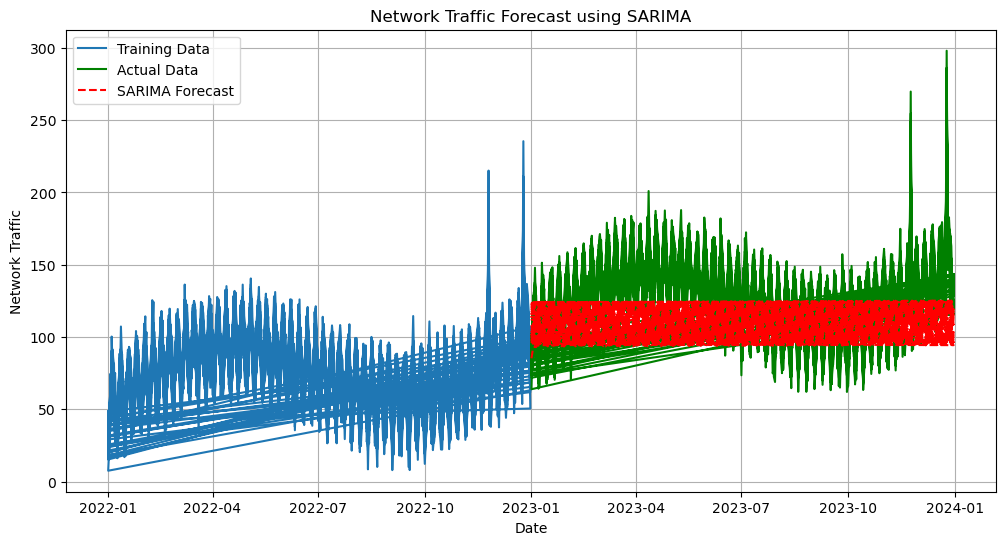

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fit SARIMA model and forecast
def fit_and_forecast_sarima(train_data, test_data, column):
    # Define SARIMA model parameters
    sarima_model = SARIMAX(train_data[column], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
    
    # Fit the model
    sarima_fit = sarima_model.fit(disp=False)
    
    # Forecast
    sarima_forecast = sarima_fit.get_forecast(steps=len(test_data))
    sarima_forecast_df = sarima_forecast.predicted_mean
    
    # Ensure indices alignment
    sarima_forecast_df.index = test_data.index
    
    # Calculate RMSE and MAPE
    rmse_sarima = np.sqrt(mean_squared_error(test_data[column], sarima_forecast_df))
    mape_sarima = mean_absolute_percentage_error(test_data[column], sarima_forecast_df)
    
    return sarima_forecast_df, rmse_sarima, mape_sarima

# Load and preprocess data
df = pd.read_csv('C:\\New folder\\Hope AI\\Time Series\\TSA_Network\\enhanced_network_traffic_data5.csv', parse_dates=['Date'], index_col='Date')
train_data = df[:'2022']
test_data = df['2023':]

# Fit SARIMA and forecast
sarima_forecast_df, rmse_sarima, mape_sarima = fit_and_forecast_sarima(train_data, test_data, 'Network_Traffic')

# Print metrics
print(f"SARIMA - RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

# Create a DataFrame to plot
forecast_dates = test_data.index
forecast_df = pd.DataFrame({'Forecast': sarima_forecast_df}, index=forecast_dates)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Network_Traffic'], label='Training Data')
plt.plot(test_data.index, test_data['Network_Traffic'], label='Actual Data', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Network Traffic')
plt.title('Network Traffic Forecast using SARIMA')
plt.legend()
plt.grid(True)
plt.show()


SARIMA - RMSE: 29.64467341158958, MAPE: 17.790799628179645
Forecast data saved to C:\New folder\Hope AI\Time Series\TSA_Network\sarima_forecast.csv


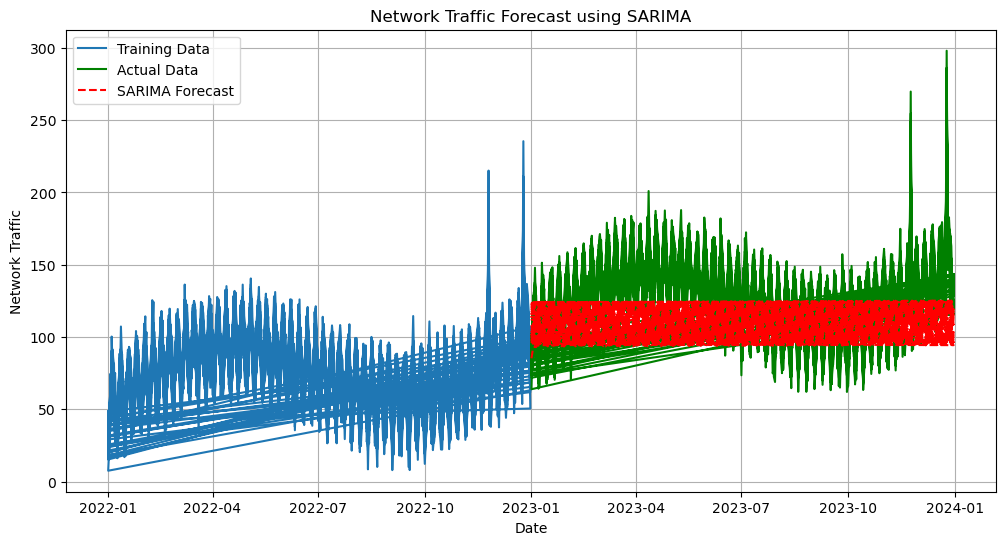

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fit SARIMA model and forecast
def fit_and_forecast_sarima(train_data, test_data, column):
    # Define SARIMA model parameters
    sarima_model = SARIMAX(train_data[column], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
    
    # Fit the model
    sarima_fit = sarima_model.fit(disp=False)
    
    # Forecast
    sarima_forecast = sarima_fit.get_forecast(steps=len(test_data))
    sarima_forecast_df = sarima_forecast.predicted_mean
    
    # Ensure indices alignment
    sarima_forecast_df.index = test_data.index
    
    # Calculate RMSE and MAPE
    rmse_sarima = np.sqrt(mean_squared_error(test_data[column], sarima_forecast_df))
    mape_sarima = mean_absolute_percentage_error(test_data[column], sarima_forecast_df)
    
    return sarima_forecast_df, rmse_sarima, mape_sarima

# Load and preprocess data
df = pd.read_csv('C:\\New folder\\Hope AI\\Time Series\\TSA_Network\\enhanced_network_traffic_data5.csv', parse_dates=['Date'], index_col='Date')
train_data = df[:'2022']
test_data = df['2023':]

# Fit SARIMA and forecast
sarima_forecast_df, rmse_sarima, mape_sarima = fit_and_forecast_sarima(train_data, test_data, 'Network_Traffic')

# Print metrics
print(f"SARIMA - RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

# Create a DataFrame to plot
forecast_dates = test_data.index
forecast_df = pd.DataFrame({'Forecast': sarima_forecast_df}, index=forecast_dates)

# Save forecast to CSV
forecast_csv_path = 'C:\\New folder\\Hope AI\\Time Series\\TSA_Network\\sarima_forecast.csv'
forecast_df.to_csv(forecast_csv_path)

print(f"Forecast data saved to {forecast_csv_path}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Network_Traffic'], label='Training Data')
plt.plot(test_data.index, test_data['Network_Traffic'], label='Actual Data', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Network Traffic')
plt.title('Network Traffic Forecast using SARIMA')
plt.legend()
plt.grid(True)
plt.show()
